# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [20]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

# import py files.
from data_cleaning import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

# Configure matplotlib for jupyter.
%matplotlib inline

## 1. Data Cleaning

In [21]:
df = pd.read_csv('student_data.csv')

In [22]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [23]:
df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)

#Imputes values to combine "other"/"unknown" fields in the marriage and education columns.
df= replace_unknowns(df)

## 2. EDA

In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,23999.0,15027.353931,8654.746941,1.0,7506.0,15027.0,22531.5,30000.0
LIMIT_BAL,23999.0,167825.729405,129915.115993,10000.0,50000.0,140000.0,240000.0,1000000.0
SEX,23999.0,1.603608,0.489158,1.0,1.0,2.0,2.0,2.0
EDUCATION,23999.0,1.783408,0.730617,0.0,1.0,2.0,2.0,3.0
MARRIAGE,23999.0,1.517897,0.524588,0.0,1.0,2.0,2.0,2.0
AGE,23999.0,35.523230,9.253986,21.0,28.0,34.0,42.0,79.0
PAY_1,23999.0,-0.014959,1.120903,-2.0,-1.0,0.0,0.0,8.0
PAY_2,23999.0,-0.134839,1.193044,-2.0,-1.0,0.0,0.0,8.0
PAY_3,23999.0,-0.165632,1.193515,-2.0,-1.0,0.0,0.0,8.0
PAY_4,23999.0,-0.217092,1.168719,-2.0,-1.0,0.0,0.0,8.0


<Figure size 1440x1080 with 0 Axes>

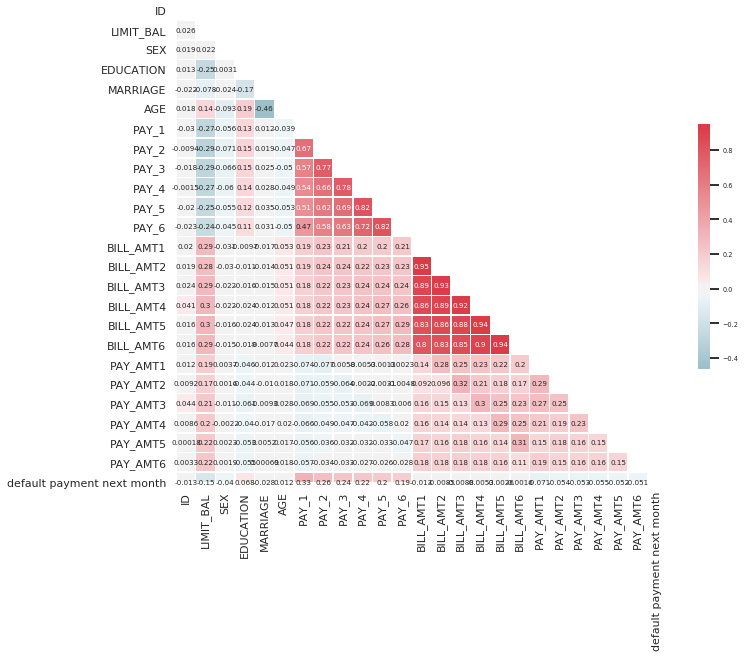

In [25]:
trimmed_heatmap(df, df.columns, font_scale=.4, figsize=(20,15))

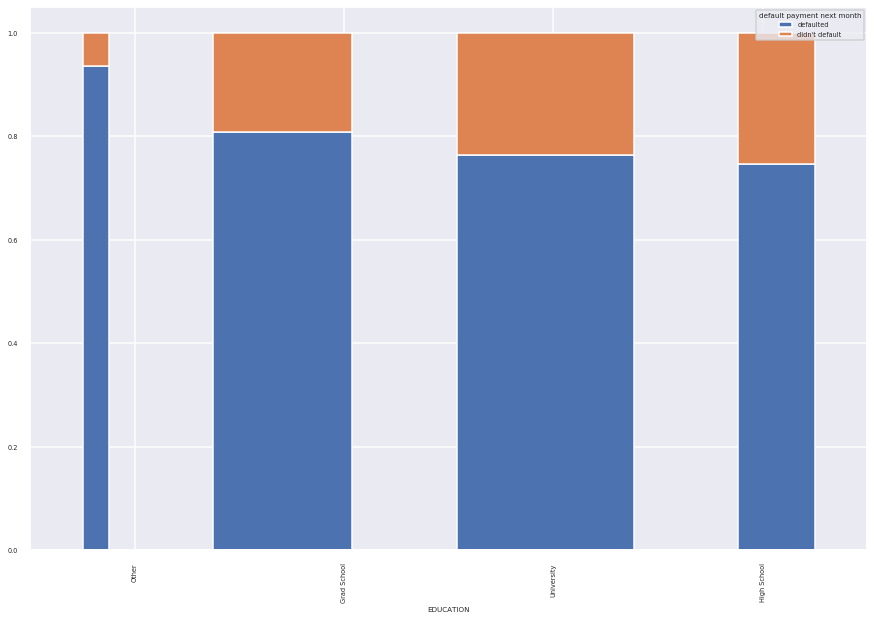

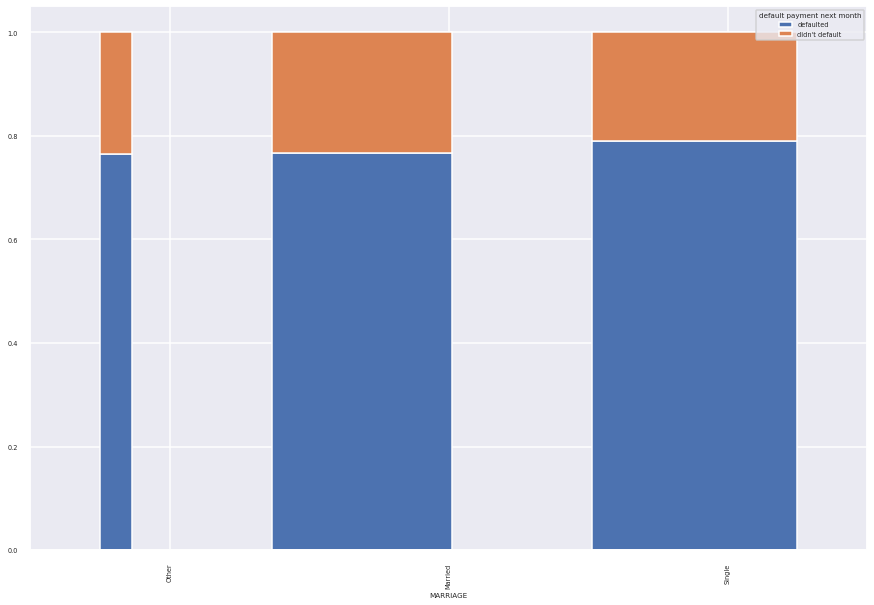

In [26]:
edu_dict = {1:'Grad School' , 2:'University' , 3:'High School' , 0:'Other'}
marriage_dict = {1:'Married' , 2:'Single' , 0:'Other'}
visualize = df.copy()
visualize['default payment next month'] = np.where(df['default payment next month'] ==0, "defaulted", "didn't default")
plot_stacked_proportion(visualize, "EDUCATION", 'default payment next month', .2, x_dict=edu_dict, palette="deep")
plot_stacked_proportion(visualize, "MARRIAGE", 'default payment next month', .2, x_dict=marriage_dict, palette="deep")

In [ ]:
# EDA for education vs default payment
sns.set(rc = {'figure.figsize':(9,7)})
sns.set_context('talk' , font_scale=0.7)
edu = sns.countplot(x = 'EDUCATION'  ,hue='default payment next month', data = df)
edu.set_xticklabels(['Graduate School' , 'University' , 'High School' , 'Other'])
plt.show()

In [ ]:
graph = Multiplot(df[selection], 3, figsize=(15,25))
graph.sb_multiplot(sns.boxplot)
# graph.sb_qq_plots(scat_kwargs)
# graph.sb_multiplot(sns.scatterplot, scat_kwargs, default_axis="x")

## 3. Feature Engineering

In [4]:
df=calculate_utilization(df)

## 4. Feature Selection

In [ ]:
df.groupby("default payment next month").mean()

In [5]:
excluded = exclude_columns(["PAY_AMT", "BILL_AMT", "payment_impact","utilization"])
selection = df.drop(columns = excluded).columns
selection

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'avg_utilization',
       'avg_payment_impact', 'debt_streak', 'debt_avg_delta'],
      dtype='object')

In [48]:
cols = df.columns
colb = pd.Index(['AGE', "EDUCATION"])
cols.isin(colb)

# cols.size
# np.full(42,True)

array([False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [62]:
target_col = "default payment next month"
categorical = {
    "nominal_features":["SEX", "EDUCATION", "MARRIAGE", "PAY_1", "PAY_2",
                    "PAY_3", "PAY_4", "PAY_5", "PAY_6",
                   ],
}

continuous = {"untransformed":["LIMIT_BAL", "avg_utilization", "avg_payment_impact",
                               "debt_streak","debt_avg_delta"],
             "transformed": {"logged": {"ID":20,}}
             }
polynomial = {"method":"choose", "columns":["avg_utilization", "avg_payment_impact", "PAY_1", "ID"]}

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [63]:
data = DataPreprocessor(df, target_col, categorical, continuous, polynomial, True, True,)
data.data_preprocessing(balance_class="upsample", scale_type="minmax", poly_degree=2)
data.X_train

Creating Dummies
Getting polynomial features of degree 2
Performing upsample
Using Min/Max scaler


,LIMIT_BAL,avg_utilization,avg_payment_impact,debt_streak,debt_avg_delta,ID_log_b20,SEX_2.0,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,...,PAY_1_5.0^2,PAY_1_5.0 PAY_1_6.0,PAY_1_5.0 PAY_1_7.0,PAY_1_5.0 PAY_1_8.0,PAY_1_6.0^2,PAY_1_6.0 PAY_1_7.0,PAY_1_6.0 PAY_1_8.0,PAY_1_7.0^2,PAY_1_7.0 PAY_1_8.0,PAY_1_8.0^2
1430,0.113924,0.089373,0.026313,0.0,0.000000,0.725947,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4222,0.012658,0.190037,0.068209,0.0,0.000000,0.891370,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6283,0.012658,0.196537,0.022092,0.0,0.000000,0.976381,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3764,0.215190,0.073558,0.005734,0.8,0.022157,0.990511,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6107,0.278481,0.037242,0.014267,0.0,0.000000,0.905387,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22949,0.050633,0.179335,0.015103,0.8,0.083733,0.935065,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22451,0.063291,0.209808,0.014947,0.0,0.000000,0.941503,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22958,0.126582,0.215167,0.021351,0.0,0.000000,0.942502,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20543,0.139241,0.107617,0.022884,1.0,0.017459,0.931128,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
class DataPreprocessor(object):
    def __init__(self, df, target, cat_features={}, cont_features={}, poly_features={}, create_dummies=False,
                 scale_dummies=False):
        self.df = df
        self.create_dummies = create_dummies
        self.scale_dummies = scale_dummies
        self._set_features(target, cat_features, cont_features, poly_features)
        self.X = pd.concat([df[self.cols.drop(labels=self.cols_generated_dummies)], self.dummies], axis=1)
        self.y = df[target]

    #Creates various attributes storing column names from specifically structured dictionaries for the
    # categorical and continuous variables.
    def _set_features(self, target, cat_features, cont_features, poly_features):
        self._parse_poly_dict(poly_features)
        self._get_cat_features(cat_features)
        self._get_cont_features(cont_features)
        self.cols_initial = self.cols_continuous.union(self.cols_categorical, sort=False)
        self.cols = self.cols_initial
        self.target = target

    #Gathers categorical column name information and creates corresponding attributes.
    def _get_cat_features(self, feature_dict):
        self.cols_nominal = self._get_indiv_feature(feature_dict, "nominal_features")
        self.cols_standard_dummies = self._get_indiv_feature(feature_dict, "standard_dummies")
        self.cols_impute_dummies = self._get_indiv_feature(feature_dict, "impute_dummies")
        if self.create_dummies:
            self._generate_dummies()
            self.cols_nominal = pd.Index([])
        else:
            self.dummies = pd.DataFrame()
            self.cols_generated_dummies = pd.Index([])
        self.cols_dummies = self.cols_standard_dummies.union(self.cols_impute_dummies, sort=False)
        self.cols_dummies = self.cols_dummies.union(self.cols_generated_dummies, sort=False)
        self.cols_categorical = self.cols_nominal.union(self.cols_dummies, sort=False)

    # Gathers continuous column name information and creates corresponding attributes, calling transformation functions if specified.
    def _get_cont_features(self, feature_dict):
        transformed_dict = self._get_feature_group(feature_dict, "transformed")
        self.cols_linear = self._get_indiv_feature(feature_dict, "untransformed")
        if transformed_dict:
            self._get_trans_features(transformed_dict)
            self.cols_continuous = self.cols_linear.union(self.cols_transformed, sort=False)
        else:
            self.cols_transformed = pd.Index([])
            self.cols_continuous = self.cols_linear

    #Gathers transformed features in the dictionary for continous features. New transformed columns are performed for whatever
    # transformations are specified.
    def _get_trans_features(self, transformed_dict):
        logged = self._get_feature_group(transformed_dict, "logged")
        pow = self._get_feature_group(transformed_dict, "exp")
        self.cols_logged = pd.Index([])
        if logged:
            self._log_features(logged)
        else:
            pass
        self.cols_transformed = self.cols_logged

    #Checks the for the existence of a key in a nested dictionary.
    def _get_feature_group(self, feature_dict, key):
        return feature_dict.get(key)

    #Checks a specific category of features being present in the passed dictionary returning an empty list if no results.
    def _get_indiv_feature(self, feature_dict, key, default=[]):
        return pd.Index(feature_dict.get(key, default))

    #Performs log transformations and gathers the new column names.
    def _log_features(self, logged_dict):
        for column, base in logged_dict.items():
            if base:
                new_col_name = f"{column}_log_b{base}"
            else:
                new_col_name = f"{column}_ln"
            self.df[new_col_name] = self.df[column].map(lambda x: math.log(x, base) if base else math.log(x))
            self._manage_poly_renames(column, pd.Index([new_col_name]))
            self.cols_logged = self.cols_logged.append(pd.Index([new_col_name]))

    # Generates dummy variables from a list of categorical columns.
    def _generate_dummies(self):
        self.dummies = pd.DataFrame()
        print("Creating Dummies")
        for column in self.cols_nominal:
            unique = self.df[column].unique().size
            if unique > 20:
                print(f"Warning: {column} has {unique} unique values")
            self.df[column] = self.df[column].astype('category')
            new_dummies = pd.get_dummies(self.df[column], prefix=column, drop_first=True)
            self._manage_poly_renames(column, new_dummies.columns)
            self.dummies = pd.concat([self.dummies, new_dummies], axis=1)
        self.cols_generated_dummies = self.dummies.columns

    def _manage_poly_renames(self, original, replacements):

        if original in self.polynomial["columns"]:
            self.polynomial["columns"] = self.polynomial["columns"].drop(labels=[original])
            self.polynomial["columns"] = self.polynomial["columns"].union(replacements, sort=False)

    def _parse_poly_dict(self, poly_dict):

        self.polynomial = {"method":poly_dict.get("method", "all")}
        self.polynomial["columns"] = pd.Index(poly_dict.get("columns", []))

    #Performs a train_test split.
    def _train_test_split(self):
        X, y = self.X, self.y
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=self.test_size, random_state=self.random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

    #Creates a scaler attribute fit to the data loaded in the object.
    def _fit_scale(self):
        self._choose_scaled_columns()
        if self.scale_type == "standard":
            print("Using standard scaler")
            self.scaler = StandardScaler()
        elif self.scale_type == "minmax":
            print("Using Min/Max scaler")
            self.scaler = MinMaxScaler()
        else:
            print("No scaling specified")
            self.scale_type = False
            return
        self.scaler.fit(self.X_train[self.cols_scaled])

    #Rescales the data with the saved scalar attribute.
    def _rescale(self):
        if self.scale_type == False:
            print("Skipping scaling")
            return
        else:
            columns = self.cols_scaled

        #Overwrites original train/test dataframes to prevent linkage errors.
        self.X_test, self.X_train = self.X_test.copy(), self.X_train.copy()

        #Calls the transform function on both the train and test data targeting only the relevant columns.
        X_train = self._transform_scale(self.X_train)
        X_test = self._transform_scale(self.X_test)
        self.X_train[columns] = X_train[columns]
        self.X_test[columns] = X_test[columns]

    #Executes the scaling but preserves the index and returns it to a DataFrame.
    def _transform_scale(self, data):
        to_transform = data[self.cols_scaled]
        indices = to_transform.index
        scaled = self.scaler.transform(to_transform)
        return pd.DataFrame(scaled, columns=self.cols_scaled, index=indices)

    #Performs class balancing using the algorithm indicated in the arguments.
    def _class_imbalance(self):
        df = pd.concat([self.X_train, self.y_train], axis=1)
        if self.balance_class == "upsample":
            print("Performing upsample")
            self._simple_resample(df)
        elif self.balance_class == "downsample":
            print("Performing downsample")
            self._simple_resample(df, down=True)
        elif self.balance_class == "smote":
            print("Performing SMOTE")
            self._smote_data()
        elif self.balance_class == "tomek":
            print("Performing Tomek Links")
            self._tomek_data()
        else:
            print("Skipping class imbalance functions")

    #Performs a random choice to upsample/downsample all values to those with the maximum or minimum counts.
    def _simple_resample(self, df, down=False):
        target = self.target
        groups = [item for item in df[target].unique()]
        counts = {group: df[df[target] == group][target].count() for group in groups}
        most, least = max(counts, key=counts.get), min(counts, key=counts.get)
        if down == False:
            goal, samples = most, counts[most]
        else:
            goal, samples = least, counts[least]
        sample_queue = [remaining for remaining in groups if remaining != goal]
        new_df = df[df[target]==goal]
        for sample in sample_queue:
            current = df[df[target]==sample]
            resampled = resample(current, replace=True, n_samples=samples, random_state=self.random_state)
            new_df = pd.concat([new_df, resampled])
        self.X_train, self.y_train = new_df.drop(self.target, axis=1), new_df[self.target]

    #Performs a SMOTE upsampling of the data. If there are nominal columns detected, it will change SMOTE algorithms.
    def _smote_data(self):
        if self.cols_nominal.size > 0:
            cats = self.X_train.columns.isin(self.cols_nominal)
            sm = SMOTENC(categorical_features=cats, sampling_strategy='not majority', random_state=self.random_state)
        else:
            sm = SMOTE(sampling_strategy='not majority', random_state=self.random_state)
        self.X_train, self.y_train = sm.fit_sample(self.X_train, self.y_train)

    #Performs tomek links. Can not handle nominal values.
    def _tomek_data(self):
        if self.cols_nominal.size > 0:
            print("Skipping Tomek Links. Cannot perform with raw categorical data. Create dummies to use.")
            return
        tl = TomekLinks()
        self.X_train, self.y_train = tl.fit_sample(self.X_train, self.y_train)

    #Creates polynomial features and creates a selection of those columns.
    def _poly_features(self):
        if type(self.poly_degree) == int:
            print(f"Getting polynomial features of degree {self.poly_degree}")
            orig_columns = self._choose_poly_columns()
            X_cont = self.X[orig_columns]
            X_cont_index = X_cont.index
            poly = PolynomialFeatures(degree=self.poly_degree, include_bias=False)
            X_poly = poly.fit_transform(X_cont)
            columns = pd.Index(poly.get_feature_names(X_cont.columns))
            poly_df = pd.DataFrame(X_poly, index=X_cont_index, columns=columns)
            self.cols_polynomial = columns.drop(labels=orig_columns)
            self.X = pd.concat([self.X[self.cols_initial], poly_df[self.cols_polynomial]], axis=1)
            self.cols = self.cols_initial.union(self.cols_polynomial, sort=False)
        else:
            print("Skipping polynomial features")
            self.poly_degree = False
            self.cols_polynomial = pd.Index([])
            self.X = self.X[self.cols_initial]

    #Creates a column list for polynomial features including or excluding dummy variables and transformed features depending
    # on arguments.
    def _choose_poly_columns(self):

        baseline = self.cols_initial.drop(labels=self.cols_nominal)
        sel = self.polynomial["columns"]
        method = self.polynomial["method"]
        if method == "choose":
            mask = baseline.isin(sel)
        elif method == "eliminate":
            mask = baseline.isin(sel) == False
        elif method == "linear":
            mask = baseline.isin(self.cols_linear)
        elif method == "no_dummies":
            mask = baseline.isin(self.cols_continuous)
        elif method == "no_transformed":
            mask = baseline.isin(self.cols_linear.union(self.cols_dummies, sort=False))
        else:
            mask = np.full(baseline.size, True)
        columns = baseline[mask]
        return columns

    #Determines whether or not dummy variables will be scaled based on an initialization argument.
    def _choose_scaled_columns(self):
        if self.scale_dummies:
            self.cols_scaled = self.cols.drop(labels=self.cols_nominal)
        else:
            self.cols_scaled = self.cols.drop(labels=self.cols_categorical)

    #Chains the commands together for polynomial features, class balancing, and scaling.
    def data_preprocessing(self, balance_class=False, scale_type=False, poly_degree=False):
        self.random_state = 1
        self.test_size = .2
        self.poly_degree = poly_degree
        self.balance_class = balance_class
        self.scale_type = scale_type
        self._poly_features()
        self._train_test_split()
        self._class_imbalance()
        self._fit_scale()
        self._rescale()

    def column_drop(self, columns):
        """Drops unwanted fetures from the column selection"""

        self.cols = self.cols.drop(labels=columns)

In [ ]:
full_value_counts(df, target_col)

In [ ]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(data.X_train, data.y_train)
model_log

## 6. Model Evaluation

In [ ]:
evaluate_model(model_log, data.X_train, data.y_train)
print()
evaluate_model(model_log, data.X_test, data.y_test)

## 7. Final Model